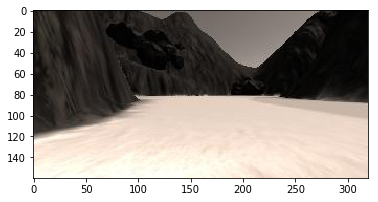

In [61]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline

# Read in the sample image
image = mpimg.imread('sample.jpg')
plt.imshow(image)

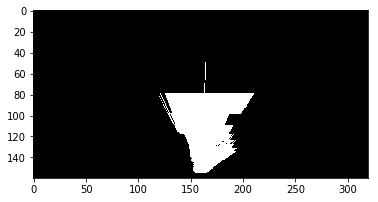

In [64]:
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an empty array the same size in x and y as the image but just a single channel
    color_select = np.zeros_like(img[:,:,0])
    # Apply the thresholds for RGB and assign 1's where threshold was exceeded
    above_thresh = ((img[:,:,0] > rgb_thresh[0]) &
                    (img[:,:,1] > rgb_thresh[1]) &
                    (img[:,:,2] > rgb_thresh[2]))
    color_select[above_thresh] = 1
    # Return the single-channel binary image
    return color_select

def perspect_transform(img):
    # Define calibration box in source (actual) and destination (desired) coordinates
    # These source and destination points are defined to warp the image
    # to a grid where each 10x10 pixel square represents 1 square meter
    dst_size = 5
    # Set a bottom offset to account for the fact that the bottom of the image 
    # is not the position of the rover but a bit in front of it
    bottom_offset = 6

    # Define a box in source (original) and 
    # destination (desired) coordinates
    source = np.float32([[118,96], [200,96], [301,140], [14,140]])
    destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                              [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                              [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                              [image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset]
                             ])

    # Get transform matrix using cv2.getPerspectivTransform()
    M = cv2.getPerspectiveTransform(source, destination)
    # Warp image using cv2.warpPerspective()
    # keep same size as input image
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    # Return the result
    return warped

# Perform color threshold on image
colorsel = color_thresh(image, rgb_thresh=(160, 160, 160))

# Perform perspective transformation on color selected image
warped = perspect_transform(colorsel)

# Plot the result
plt.imshow(warped, cmap='gray')
#plt.show()

Extract the pixel positions of all navigable terain (white) pixels and then transform those values to "rover-centric" coordinates, meaning a coordinate frame where the rover camera is at `(x, y) = (0, 0)`.

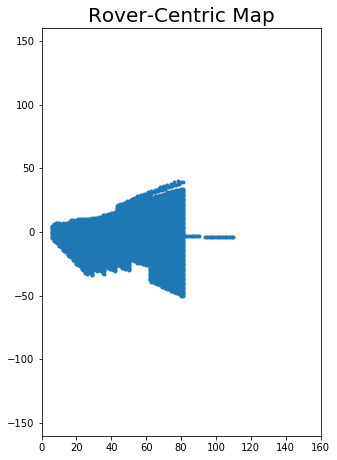

In [65]:
def rover_coords(binary_img):
    # Extract xpos and ypos pixel positions from binary_img
    xpos, ypos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position
    # being at the center bottom of the image
    x_pixel = -(xpos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(ypos - binary_img.shape[1]/2).astype(np.float)
    return x_pixel, y_pixel

xpix, ypix = rover_coords(warped)

fig = plt.figure(figsize=(5, 7.5))
plt.plot(xpix, ypix, '.')
plt.xlim(0, 160)
plt.ylim(-160, 160)
plt.title('Rover-Centric Map', fontsize=20)
#plt.show()